In [43]:
import nltk

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from collections import Counter
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix

pd.options.display.max_colwidth = 200

lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /home/roya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/roya/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/roya/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [52]:

#data = pd.read_csv('./DS1_clean.csv', encoding='utf-8')

datasets = ['DS1_clean.csv']
data= pd.concat([pd.read_csv(dataset) for dataset in datasets], axis=0, 
               ignore_index=True)

data.head()

,Unnamed: 0,text,label,category
0,0,".omg why are poc wearing fugly blue contacts so in, it is 2018. please make it stop.",False,normal
1,1,.Sorry but most of the runners popular right now are just plain fugly.,False,normal
2,2,".those jeans are hideous, and I?m afraid he?s bought the entire collection of those fugly sunglasses ??",False,normal
3,3,.I had to dress up for a presentation in class today and I?m giving some serious Mr. Grey zaddy vibes if I do say so myself,False,normal
4,4,.Am I the only one who thinks justin bieber is fugly af now?,False,normal


In [53]:
data.describe()
data['label'] = data['label'].apply(lambda label: 0 if label == False else 1)
data['label'].isnull().any()

False

Percentage of Offensive language: 40.08%


Text(0.5, 1.0, 'Empirical distribution of the labels')

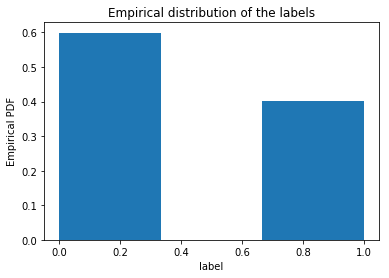

In [54]:
# Empirical distribution of the labels
print('Percentage of Offensive language: {0}%'.format(round(100 * data['label'].sum() / len(data['label']), 2)))
plt.hist(data['label'], bins=3, weights=np.ones(len(data['label'])) / len(data['label']))
plt.xlabel('label')
plt.ylabel('Empirical PDF')
plt.title('Empirical distribution of the labels')

In [55]:
# extract spams and hams
offensive = data['text'].iloc[(data['label'] == 1).values]
normal = data['text'].iloc[(data['label'] == 0).values]



In [56]:
data['text_length'] = data['text'].apply(lambda text: len(text))
data.sort_values(by='text_length', ascending=False)
# most of offensie are long sentences? 
#roya: no

,Unnamed: 0,text,label,category,text_length
595,596,".I really take it as a vast insult if a nigga asks me to fuck him!!!', 'Like what rubbish is that ???????? listen here fag I only eat pussy!!!.",0,normal,143
565,566,". .pilotwilliams2u: My mom asked me what ""JDMLOL"" mean and I told her.', ""She said that's not right because I would get offended if someone m""]",0,normal,143
575,576,". .fattydaddy7: Just had a flashback to August, 1989.', 'I was in Hamburg, Germany and had a hooker pull my shirt over my head hockey fight s.",0,normal,142
571,572,". .UF2: Left has already established a moral justification for deploying violence against wrong-thinkers.', 'If one is black and kills someon.",0,normal,142
110,111,.My day been so terrible y?all my dumbass got out the car didn?t put the car in park and almost crashed into the corner store like wtf ??‍??.,0,normal,141
130,131,"Yes, by all means.', ""Don't criticize something wrong."", 'Just find something to distract you from it.', ""Uh, that doesn't work."", '#Dumbass.",0,normal,141
10,10,This luxury bldg they?re putting up across from .thepinhook is so fugly. I would still be mad even if it were aesthetically pleasing but ew.,0,normal,140
108,109,".My dumbass forgot my work uniform on my bed.. first time I ever done that shit.', 'Now I gotta wear hospital scrubs.', 'Hella weird ??‍??.",0,normal,139
563,564,". .DecolonialBlack: Black council member: ""we have great race relations in this town"" So why did the white council members sit silent when.",0,normal,139
596,597,Let's give these Nutella filled donuts a shot to be anything important like a party leader because he has his arm around his gf what a fag,0,normal,138


Text(0.5, 1.0, 'Empirical distribution of the message lengths')

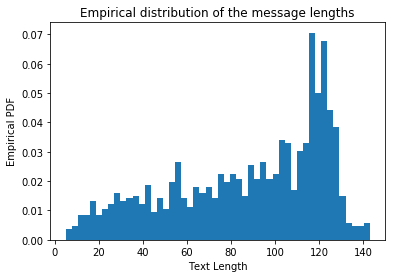

In [57]:
plt.hist(data['text_length'], bins=50, weights=np.ones(len(data))/len(data))
plt.xlabel('Text Length')
plt.ylabel('Empirical PDF')
plt.title('Empirical distribution of the message lengths')

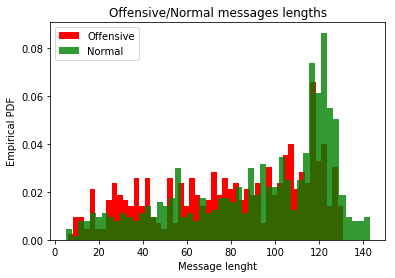

In [58]:
plt.hist(offensive.apply(lambda x: len(x)),
         bins=50,
         weights=np.ones(len(offensive)) / len(offensive),
         facecolor='r',
         label='Offensive')
plt.hist(normal.apply(lambda x: len(x)),
         bins=50,
         weights=np.ones(len(normal)) / len(normal),
         facecolor='g',
         alpha=0.8,
         label='Normal')
plt.xlabel('Message lenght')
plt.ylabel('Empirical PDF')
plt.title('Offensive/Normal messages lengths')
def preprocess(text):
    result = []
    for token in simple_preprocess(text):
        if token not in STOPWORDS and len(token) > 3:
            result.append(lemmatizer.lemmatize(token, pos='v'))
    return " ".join(result).strip()
plt.legend()

In [69]:
from nltk.corpus import stopwords
slang = pd.read_csv('twitter_moods/slang.txt',sep="-",header = None, error_bad_lines=False)
slang.columns = ['short_form', 'long_form']
slang = {str(k):str(v) for k, v in list(zip(slang.short_form, slang.long_form))}
pattern = re.compile(r'\b(' + '|'.join(re.escape(key) for key in slang.keys()) + r')\b')

data['text_prep'] = data.text.map(lambda t: pattern.sub(lambda x: slang[x.group()], t))



def preprocess(text):
    result = []
    for token in simple_preprocess(text):
        if token not in STOPWORDS and len(token) > 3:
            result.append(lemmatizer.lemmatize(token, pos='v'))
    return " ".join(result).strip()


    
    
def clean_tweets(df):
    URL = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    MENTION = r'@[A-Za-z0-9_]+'
    RT = r'RT '
    LINE = r'\n'
    AND = r'&amp;'
    TRUNCATED = r'[^\s]+…'
    EMOJI = r'\"\s|\s\"|&#\d+|@[A-Za-z0-9_]+|[:;#.&,!]|http|\d+_\w+'

    pattern_list = [URL, MENTION, LINE, AND, TRUNCATED, EMOJI]

    for i, t in df.items():
        for p in pattern_list:
            pattern = re.compile(p, re.IGNORECASE)
            t = pattern.sub("", t).strip()
        # preprocessing text
        t = preprocess(t)
        df[i] = t

    #return df
    
offensive2 = data['text_prep'].iloc[(data['label'] == 1).values]
normal2 = data['text_prep'].iloc[(data['label'] == 0).values]


clean_tweets(offensive)
clean_tweets(normal)
clean_tweets(offensive2)
clean_tweets(normal2)


b'Skipping line 131: expected 2 fields, saw 3\nSkipping line 136: expected 2 fields, saw 3\nSkipping line 358: expected 2 fields, saw 3\nSkipping line 359: expected 2 fields, saw 3\nSkipping line 397: expected 2 fields, saw 3\nSkipping line 532: expected 2 fields, saw 3\nSkipping line 622: expected 2 fields, saw 3\nSkipping line 656: expected 2 fields, saw 3\nSkipping line 672: expected 2 fields, saw 3\nSkipping line 802: expected 2 fields, saw 3\nSkipping line 803: expected 2 fields, saw 3\nSkipping line 891: expected 2 fields, saw 3\nSkipping line 1086: expected 2 fields, saw 3\nSkipping line 1097: expected 2 fields, saw 3\nSkipping line 1152: expected 2 fields, saw 4\nSkipping line 1153: expected 2 fields, saw 4\nSkipping line 1163: expected 2 fields, saw 3\nSkipping line 1179: expected 2 fields, saw 3\nSkipping line 1232: expected 2 fields, saw 3\nSkipping line 1371: expected 2 fields, saw 3\nSkipping line 1424: expected 2 fields, saw 3\nSkipping line 1602: expected 2 fields, saw 3

In [70]:
# most common words in spam and ham
offensive_tokens = []
for word in offensive:
    offensive_tokens += nltk.tokenize.word_tokenize(word)
normal_tokens = []
for word in normal:
    normal_tokens += nltk.tokenize.word_tokenize(word)
print(offensive_tokens[:10])
print(normal_tokens[:10])


['good', 'fugly', 'fugly', 'slobs', 'shirt', 'message', 'unnecessary', 'girl', 'nastiest', 'skank']
['wear', 'fugly', 'blue', 'contact', 'stop', 'sorry', 'runners', 'popular', 'right', 'plain']


In [71]:
# most common words in spam and ham
offensive_tokens2 = []
for word in offensive2:
    offensive_tokens2 += nltk.tokenize.word_tokenize(word)
normal_tokens2 = []
for word in normal2:
    normal_tokens2 += nltk.tokenize.word_tokenize(word)
print(offensive_tokens2[:10])
print(normal_tokens2[:10])

['good', 'fuck', 'ugly', 'fugly', 'slobs', 'shirt', 'message', 'unnecessary', 'girl', 'nastiest']
['piece', 'crap', 'wear', 'fuck', 'ugly', 'blue', 'contact', 'stop', 'sorry', 'runners']


In [64]:
data.head(20)

,Unnamed: 0,text,label,category,text_length,text_prep
0,0,".omg why are poc wearing fugly blue contacts so in, it is 2018. please make it stop.",0,normal,84,".oh my God why are Piece of crap wearing fucking ugly blue contacts so in, it is 2018. please make it stop."
1,1,.Sorry but most of the runners popular right now are just plain fugly.,0,normal,70,.Sorry but most of the runners popular right now are just plain fucking ugly.
2,2,".those jeans are hideous, and I?m afraid he?s bought the entire collection of those fugly sunglasses ??",0,normal,103,".those jeans are hideous, and I?am afraid he?s bought the entire collection of those fucking ugly sunglasses ??"
3,3,.I had to dress up for a presentation in class today and I?m giving some serious Mr. Grey zaddy vibes if I do say so myself,0,normal,123,.I had to dress up for a presentation in class today and I?am giving some serious Mr. Grey zaddy vibes if I do say so myself
4,4,.Am I the only one who thinks justin bieber is fugly af now?,0,normal,60,.Am I the only one who thinks justin bieber is fucking ugly assface now?
5,5,We carry on? We as in fugly lookin unwanted people?,0,normal,51,We carry on? We as in fucking ugly lookin unwanted people?
6,6,"Don?t know what?s worse, the fact he?s hoying milk in before the water or his fat fugly face at the end of that vid.",0,normal,116,"Don?t know what?s worse, the fact he?s hoying milk in before the water or his fat fucking ugly face at the end of that Video."
7,7,"Enjoy your New Smyrna Beach..full of seaweed, shallow fugly green water and sharks. Nothing comp.",0,normal,98,"Enjoy your New Smyrna Beach..full of seaweed, shallow fucking ugly green water and sharks. Nothing Computer."
8,8,Yeah honestly that?s fugly.,0,normal,27,Yeah honestly that?s fucking ugly.
9,9,No one wants to see those fugly 3T bikes?,0,normal,41,No one wants to see those fucking ugly 3T bikes?


In [11]:
most_common_tokens_in_offensive = Counter(offensive_tokens).most_common(20)
most_common_tokens_in_normal = Counter(normal_tokens).most_common(20)
print(most_common_tokens_in_offensive)
print(most_common_tokens_in_normal)

[('bitch', 11148), ('like', 2409), ('hoe', 2324), ('fuck', 2215), ('pussy', 2091), ('shit', 1275), ('nigga', 1199), ('know', 835), ('niggas', 779), ('love', 657), ('want', 632), ('look', 624), ('na', 573), ('think', 561), ('faggot', 528), ('go', 526), ('talk', 515), ('tell', 482), ('need', 468), ('trash', 459)]
[('trash', 688), ('bird', 466), ('like', 305), ('charlie', 255), ('yellow', 219), ('yankees', 217), ('look', 131), ('color', 124), ('think', 116), ('go', 113), ('want', 112), ('monkey', 110), ('know', 107), ('ghetto', 107), ('game', 104), ('love', 99), ('good', 92), ('mock', 89), ('time', 85), ('talk', 81)]


In [12]:
data, test_data = train_test_split(data, test_size=0.3)
print('Train-valid data length: {0}'.format(len(data)))
print('Test data length: {0}'.format(len(test_data)))


Train-valid data length: 17348
Test data length: 7435


In [13]:
binary_vectorizer = CountVectorizer(binary=True)
count_vectorizer = CountVectorizer()
tfidf_vectorizer = TfidfVectorizer(min_df=0., max_df=1., use_idf=True)

In [14]:
def feature_extraction(df, test=False):
    if not test:
        tfidf_vectorizer.fit(df['text'])
    
    X = np.array(tfidf_vectorizer.transform(df['text']).todense())
    return X


In [15]:
train_df, valid_df = train_test_split(data, test_size=0.3)

X_train = feature_extraction(train_df)
y_train = train_df['label'].values

X_valid = feature_extraction(valid_df, test=True)
y_valid = valid_df['label'].values


In [16]:
tv_matrix = tfidf_vectorizer.fit_transform(train_df['text']).toarray()
vocab = tfidf_vectorizer.get_feature_names()
pd.DataFrame(np.round(tv_matrix, 2), columns=vocab)

,00,000,0000000000000,003,007,007m_h,00_jackie,00am,00pm,00sexilexi00,...,zukwj2ve2d,zulema,zv8zsmhnlm,zvymcxquta,zwithr,zwnbhpdz8e,zxuxfxpzi7,zzachbarness,zzkagxivlu,zzzentropy
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12138,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12140,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12141,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
clfs = {
    'mnb': MultinomialNB(),
    'gnb': GaussianNB(),
    'svm1': SVC(kernel='linear'),
    #'svm2': SVC(kernel='rbf'),
    #'svm3': SVC(kernel='sigmoid'),
    #'mlp1': MLPClassifier(),
    #'mlp2': MLPClassifier(hidden_layer_sizes=[100, 100]),
    'ada': AdaBoostClassifier(),
    'dtc': DecisionTreeClassifier(),
    'rfc': RandomForestClassifier(),
    'gbc': GradientBoostingClassifier(),
    'lr': LogisticRegression()
}

In [ ]:
f1_scores = dict()
for clf_name in clfs:
    print(clf_name)
    clf = clfs[clf_name]
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_valid)
    f1_scores[clf_name] = f1_score(y_pred, y_valid)



mnb
gnb


In [1]:
f1_scores

NameError: name 'f1_scores' is not defined